<a href="https://colab.research.google.com/github/sucharitha93/EIP4/blob/master/Week%205%20/%20Mobilenet_PersonAttributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
convolutional_neural_network.png  hvc_annotations.csv  sample_data/
gdrive/                           resized/


In [3]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import mobilenet, mobilenet_v2


Using TensorFlow backend.


In [4]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [5]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True,augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
#        if self.augmentation is not None:
#          images = self.augmentation.flow(images,shuffle=False).next()
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [8]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
4948,resized/4949.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
165,resized/166.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0
2145,resized/2146.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
12180,resized/12182.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
11607,resized/11609.jpg,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0


In [0]:
##################################cutout######################################
import cv2
import numpy as np
def Cutout(img,n_holes=1,length=112):
  #h = img.size(1)
  #w = img.size(2)
  mean_0=np.mean(img[:,:,0])
  mean_1=np.mean(img[:,:,1])
  mean_2=np.mean(img[:,:,2])
  
  border=112
  img= cv2.copyMakeBorder(img,border,border,border,border,cv2.BORDER_CONSTANT,value=[0,0,0])

  h,w,c=img.shape


  for n in range(n_holes):
    y = np.random.randint(h)
    x = np.random.randint(w)

    y1 = np.clip(y - length // 2, 0, h)
    y2 = np.clip(y + length // 2, 0, h)
    x1 = np.clip(x - length // 2, 0, w)
    x2 = np.clip(x + length // 2, 0, w)
    
    img[y1: y2, x1: x2,:] = [mean_0,mean_1,mean_2]

    img=img[112:336,112:336,:]	
    print(img)
 
  return img


In [0]:
from keras.preprocessing.image import ImageDataGenerator
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=128,augmentation=ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.0,
        featurewise_center=1,
        featurewise_std_normalization=1,
        #preprocessing_function=Cutout()
    ))
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False , augmentation=None)

In [10]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [11]:
backbone = mobilenet_v2.MobileNetV2(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(128, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.45)(in_layer)
    neck = Dense(64, activation="relu")(neck)
    neck = Dropout(0.25)(in_layer)
    neck = Dense(64, activation="relu")(neck)
    neck = Dropout(0.45)(in_layer)
    neck = Dense(32, activation="relu")(neck)
    return neck

def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = Dropout(0.4)(backbone.output)
age = Flatten(name="aflatten")(age)
age = build_head("age", build_tower(age))
weight = build_head("weight", build_tower(neck))
bag = Dropout(0.4)(backbone.output)
bag = Flatten(name="bflatten")(bag)
bag = build_head("bag", build_tower(bag))
footwear = Dropout(0.4)(backbone.output)
footwear = Flatten(name="fflatten")(footwear)
footwear = build_head("footwear", build_tower(footwear))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

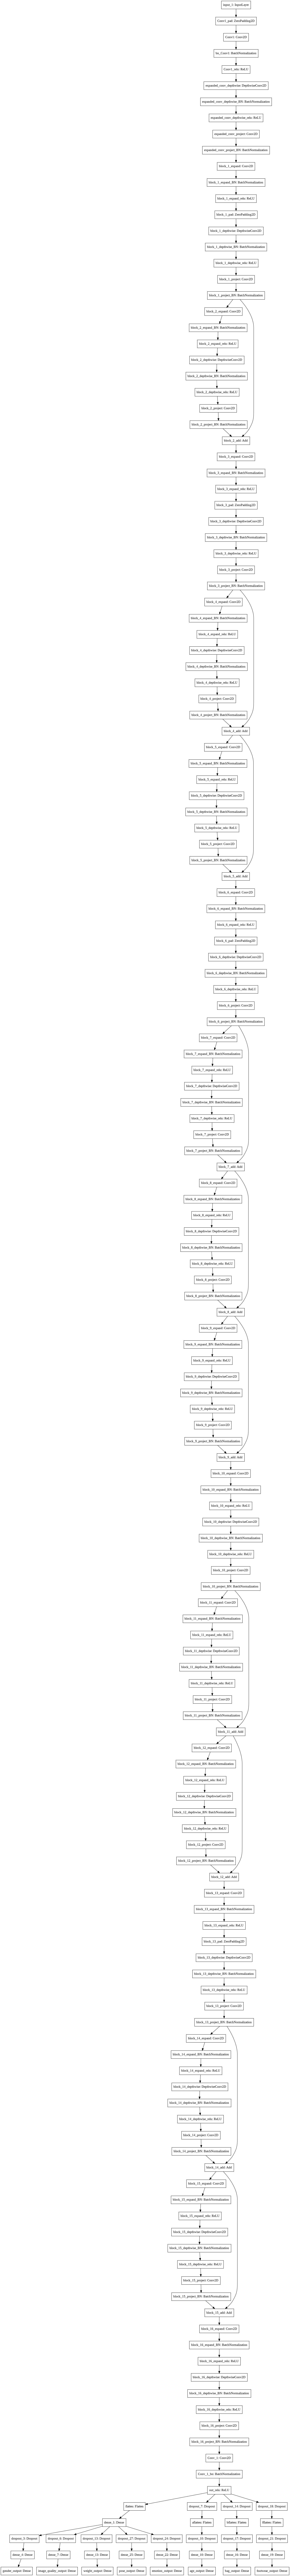

In [12]:
model.summary()
from keras.utils import plot_model
plot_model(model, to_file='convolutional_neural_network.png')

In [0]:
# freeze backbone
for layer in backbone.layers:
	layer.trainable = True

In [0]:
losses = {
    "gender_output": "binary_crossentropy",
    "image_quality_output": "categorical_crossentropy",
    "age_output": "categorical_crossentropy",
    "weight_output": "categorical_crossentropy",
    "bag_output": "categorical_crossentropy" ,
    "footwear_output":"categorical_crossentropy",
    "pose_output" :"categorical_crossentropy",
    "emotion_output":"categorical_crossentropy"
 }
loss_weights = {
    "gender_output": 1, 
    "image_quality_output": 1, 
    "age_output": 1,
    "weight_output":1,
    "bag_output":1,
    "footwear_output":1,
    "pose_output" :1,
    "emotion_output":1
    }

metrics = {
    "gender_output": "accuracy",
    "image_quality_output": "accuracy",
    "age_output": "accuracy",
    "weight_output": "accuracy",
    "bag_output": "accuracy" ,
    "footwear_output":"accuracy",
    "pose_output" :"accuracy",
    "emotion_output":"accuracy"

 }
opt = Adam(lr=0.001)
model.compile(
    optimizer=opt,
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=metrics
)

In [17]:
model_info=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=10, 
    epochs=20,
    verbose=1
)

print(model_info)
# compute test accuracy
#print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))


Epoch 1/20
90/90 [==============================] - 85s 950ms/step - loss: 22.3071 - gender_output_loss: 2.3576 - image_quality_output_loss: 2.8392 - age_output_loss: 4.3507 - weight_output_loss: 2.5002 - bag_output_loss: 2.7411 - footwear_output_loss: 2.8636 - pose_output_loss: 2.4927 - emotion_output_loss: 2.1619 - gender_output_acc: 0.5139 - image_quality_output_acc: 0.5263 - age_output_acc: 0.3250 - weight_output_acc: 0.6212 - bag_output_acc: 0.5553 - footwear_output_acc: 0.4269 - pose_output_acc: 0.6050 - emotion_output_acc: 0.7024 - val_loss: 62.7015 - val_gender_output_loss: 8.9449 - val_image_quality_output_loss: 7.3001 - val_age_output_loss: 13.0359 - val_weight_output_loss: 5.7601 - val_bag_output_loss: 6.8672 - val_footwear_output_loss: 10.0674 - val_pose_output_loss: 6.2500 - val_emotion_output_loss: 4.4759 - val_gender_output_acc: 0.4360 - val_image_quality_output_acc: 0.5423 - val_age_output_acc: 0.1860 - val_weight_output_acc: 0.6391 - val_bag_output_acc: 0.5691 - val_f

dict_keys(['val_loss', 'val_gender_output_loss', 'val_image_quality_output_loss', 'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss', 'val_emotion_output_loss', 'val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'loss', 'gender_output_loss', 'image_quality_output_loss', 'age_output_loss', 'weight_output_loss', 'bag_output_loss', 'footwear_output_loss', 'pose_output_loss', 'emotion_output_loss', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc'])


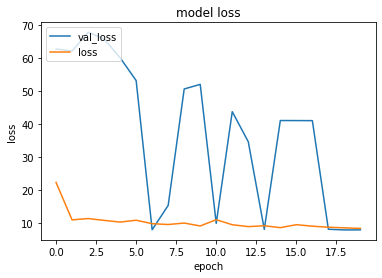

In [18]:
import matplotlib.pyplot as plt
print(model_info.history.keys())
'''
for key in model_info.history:
  plt.plot(model_info.history[key])
'''
plt.plot(model_info.history['val_loss'])
plt.plot(model_info.history['loss'])
# summarize history for accuracy
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()


In [0]:
#model.summary()

# Score trained model.
scores = model.evaluate(valid_gen)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)

In [0]:
max(scores)